In [1]:
import matplotlib.pyplot as plt

from neuronunit.optimisation.optimization_management import dtc_to_rheo
import math
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import numpy as np
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["IZHI"].items()}
from neuronunit.capabilities.spike_functions import spikes2widths, spikes2thresholds
from quantities import ms
from neuronunit.tests.base import AMPL, DELAY, DURATION
from neuronunit.optimisation.data_transport_container import DataTC
from quantities import mV
from elephant.spike_train_generation import threshold_detection
import neo
# Membrane potential trace (1D numpy array) to matrix of spike snippets (2D numpy array)
def get_spike_waveforms(vm, threshold=0.0*mV, width=10*ms):
    """
    Membrane potential trace (1D numpy array) to matrix of
    spike snippets (2D numpy array)

    Inputs:
     vm: a neo.core.AnalogSignal corresponding to a membrane potential trace.
     threshold: the value (in mV) above which vm has to cross for there
                to be a spike.  Scalar float.
     width: the length (in ms) of the snippet extracted,
            centered at the spike peak.

    Returns:
     a neo.core.AnalogSignal where each column contains a membrane potential
     snippets corresponding to one spike.
    """
    spike_train = threshold_detection(vm, threshold=threshold)

    # Fix for 0-length spike train issue in elephant.
    if len(spike_train) == 0:
        diff,times = get_diff(vm)
        temp = float(np.mean(vm))+float(np.std(vm))
        spike_train = threshold_detection(vm,threshold=temp)
        if len(spike_train) == 0:
            spike_train = threshold_detection(vm,threshold=np.max(vm))
            if len(spike_train) == 0:
                return None

    too_short = False
    too_long = False
    last_t = spike_train[-1]
    first_t = spike_train[0]

    snippets = [vm.time_slice(t-width/2, t) for t in spike_train]


    result = neo.core.AnalogSignal(np.array(snippets).T.squeeze(),
                                   units=vm.units,
                                   sampling_rate=vm.sampling_rate)
    return result



def spikes2thresholds_debug(spike_waveforms,axs):
    """
    IN:
     spike_waveforms: Spike waveforms, e.g. from get_spike_waveforms().
        neo.core.AnalogSignal
    OUT:
     1D numpy array of spike thresholds, specifically the membrane potential
     at which 1/10 the maximum slope is reached.

    If the derivative contains NaNs, probably because vm contains NaNs
    Return an empty list with the appropriate units

    """
    try:
        n_spikes = spike_waveforms.shape[1]
    except:
        return None
        #return thresholds * spike_waveforms.units


    thresholds = []
    if n_spikes > 1:
        # good to know can handle multispikeing
        pass
    for i in range(n_spikes):
        s = spike_waveforms[:, i].squeeze()
        #plt.plot(s.times,s.magnitude)        

        axs.plot([i for i in range(0,len(s))],s)        

        s = np.array(s)
        dvdt = np.diff(s)
        for j in dvdt:
            if math.isnan(j):
                return thresholds * spike_waveforms.units
        try:
            trigger = dvdt.max()/10.0
            print(trigger)
        except:
            return None
        try:
            x_loc = np.where(dvdt >= trigger)[0][0]
            thresh = (s[x_loc]+s[x_loc+1])/2
            
        except:
            thresh = None
        thresholds.append(thresh)
        axs.scatter(x_loc,thresh)
        axs.axvline(x_loc)
                
    return axs,thresh


0.02723521901046011
0.02742301889813829
0.02710445203278462
0.02729778275161206
0.027052696074933526
0.026983152126904185
0.026886331354264704
0.026983218103520522
0.026842198509674998
0.026939050185987745
0.026931992700503317
0.026909254515515946
0.026873797722850014
0.027021749666605928
0.026870218211198872
0.026773564474840583
0.026821284246470123
0.026765755722946115
0.026955513573366768
0.026824462163988573


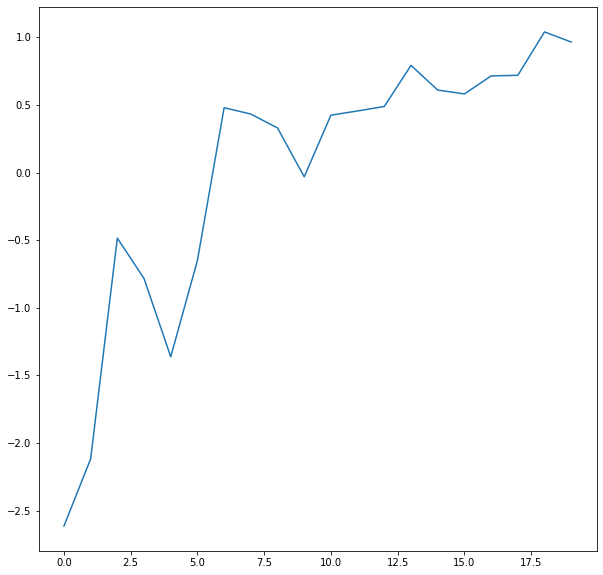

In [2]:


fig, axs = plt.subplots(20,1,figsize=(10, 10))

i = 0
thresholds = []
for slider_value in np.linspace(0.01, 0.1, 20):

  dtc = DataTC(backend="IZHI",attrs=attrs)
  dtc.attrs['a'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm,width=5*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  #print(thresh)
  axs[i].set_title(label = str(dtc.attrs['a'])+str(thresh))
  i +=1
  thresholds.append(thresh)

#plt.plot(range(0,len(thresholds)),thresholds)
#plt.show()

plt.clf()

plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()

6.664957413278216e-05
7.257887813025832e-05
8.778631496966227e-05
6.938184752627307e-05
0.00010282154351557438
7.114549779458912e-05
0.00014819991023244937
7.600130172349395e-05
0.0001512383905016179
0.00015505214317457217


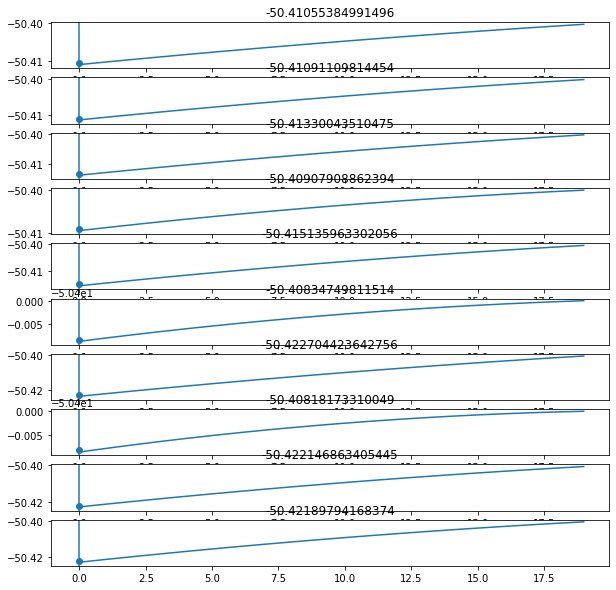

In [3]:

attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["ADEXP"].items()}

fig, axs = plt.subplots(10,1,figsize=(10, 10))
i = 0
plotxvec = np.linspace(MODEL_PARAMS['ADEXP']['a'][0],MODEL_PARAMS['ADEXP']['a'][1],10)
thresholds = []
for slider_value in plotxvec:

  dtc = DataTC(backend="ADEXP",attrs=attrs)
  dtc.attrs['a'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  axs[i].set_title(label = str(thresh))
  i +=1
  thresholds.append(thresh)
#plt.clf()



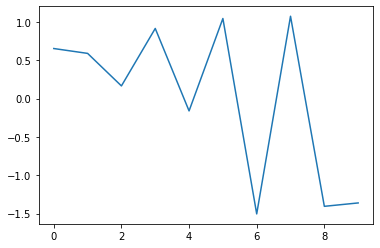

In [4]:
plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()

0.5905573517858534
0.5905573517864849
0.5905573517872933
0.5905573517866576
0.5905573517859762
0.590557351786561
0.5905573517872711
0.5905573517859175
0.5905573517865772
0.5905573517865845


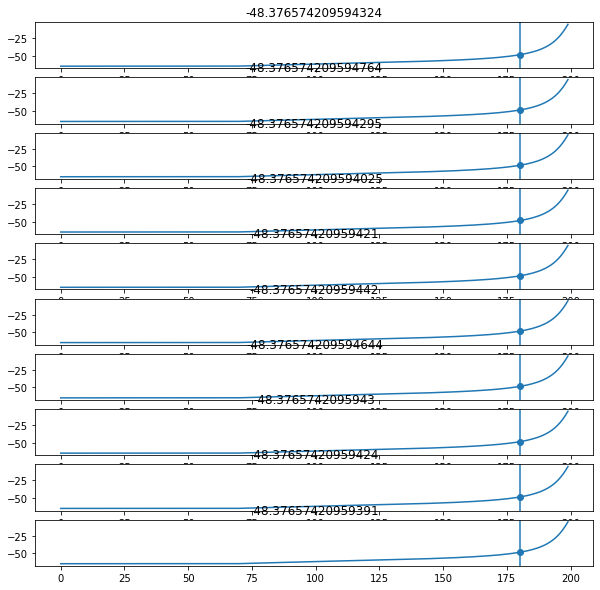

In [5]:
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["NEURONHH"].items()}

fig, axs = plt.subplots(10,1,figsize=(10, 10))
i = 0
plotxvec = np.linspace(MODEL_PARAMS['NEURONHH']['Ra'][0],MODEL_PARAMS['NEURONHH']['Ra'][1],10)
thresholds = []
for slider_value in plotxvec:

  dtc = DataTC(backend="NEURONHH",attrs=attrs)
  dtc.attrs['Ra'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  axs[i].set_title(label = str(thresh))
  i +=1
  thresholds.append(thresh)


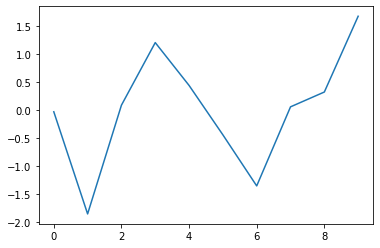

In [6]:
plt.clf()

plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()

In [7]:
'''
from neuronunit.models.reduced import ReducedModel
import pickle
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["IZHI"].items()}
from sciunit.scores import ZScore
tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests

fig, axs = plt.subplots(10,1,figsize=(10, 10))

i = 0
thresholds = []
for slider_value in np.linspace(0.01, 0.1, 10):
  
  m = ReducedModel("/home/user/safe2/neuronunit/neuronunit/models/NeuroML2/Izh2007One.net.nml",backend="jNeuroML",attrs=attrs)
  attrs['a'] = slider_value
  m.set_attrs(**attrs)
  #nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests
  nu_tests[0].score_type = ZScore
  pred = nu_tests[0].generate_prediction(m)
  print(pred)
  #dtc = dtc_to_rheo(dtc)
  #model = dtc.dtc_to_model()
  #model.attrs = model._backend.default_attrs
  #m.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  m._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm,width=10*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  #print(thresh)
  axs[i].set_title(label = str(dtc.attrs['a'])+str(thresh))
  i +=1
  thresholds.append(thresh)

plt.plot(range(0,len(thresholds)),thresholds)
plt.show()

plt.clf()

plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()
'''

'\nfrom neuronunit.models.reduced import ReducedModel\nimport pickle\nattrs = {k:np.mean(v) for k,v in MODEL_PARAMS["IZHI"].items()}\nfrom sciunit.scores import ZScore\ntests = pickle.load(open("processed_multicellular_constraints.p","rb"))\nnu_tests = tests[\'Hippocampus CA1 pyramidal cell\'].tests\n\nfig, axs = plt.subplots(10,1,figsize=(10, 10))\n\ni = 0\nthresholds = []\nfor slider_value in np.linspace(0.01, 0.1, 10):\n  \n  m = ReducedModel("/home/user/safe2/neuronunit/neuronunit/models/NeuroML2/Izh2007One.net.nml",backend="jNeuroML",attrs=attrs)\n  attrs[\'a\'] = slider_value\n  m.set_attrs(**attrs)\n  #nu_tests = tests[\'Hippocampus CA1 pyramidal cell\'].tests\n  nu_tests[0].score_type = ZScore\n  pred = nu_tests[0].generate_prediction(m)\n  print(pred)\n  #dtc = dtc_to_rheo(dtc)\n  #model = dtc.dtc_to_model()\n  #model.attrs = model._backend.default_attrs\n  #m.attrs.update(dtc.attrs)\n  uc = {\'amplitude\':dtc.rheobase,\'duration\':DURATION,\'delay\':DELAY}\n  m._backend.injec